# Robust Topological Photonics using Embedded Qubits & Holographic Qudits Under Realistic Noise

This notebook implements a simulation framework for fault-tolerant topological photonic quantum computing. It demonstrates:

- Construction of an SSH Hamiltonian in an extended Hilbert space (modeling each site as a two-level system).
- Realistic noise modeling using proper lowering (annihilation) operators for amplitude damping.
- Quantitative analysis of disorder via the inverse participation ratio (IPR).
- Embedded qubit operations using topologically protected edge states.
- Holographic OAM qudit encoding with a DFT-based transformation and a Kerr-like nonlinear interaction.
- Full-lattice noise modeling using the Lindblad master equation.
- 2D Photonic Chern insulator analysis via Berry curvature and Chern number calculations.

The notebook includes detailed code and analysis of numerical outputs and plots.

In [3]:
import numpy as np
import qutip as qt
import matplotlib.pyplot as plt

plt.style.use('ggplot')
np.random.seed(42)

## 1. Utility Functions for Extended Hilbert Space

We model each lattice site as a two-level system (representing vacuum and one excitation). The following functions construct operators acting on individual sites in the full Hilbert space (which is the tensor product of each site’s 2-dimensional space).

In [4]:
def operator_on_site(op, i, N):
    """Constructs an operator acting as 'op' on site i in an N-site tensor product space."""
    op_list = [qt.qeye(2) for _ in range(N)]
    op_list[i] = op
    return qt.tensor(op_list)

def destroy_site(i, N):
    """Returns the annihilation (lowering) operator on site i."""
    return operator_on_site(qt.destroy(2), i, N)

def create_site(i, N):
    """Returns the creation (raising) operator on site i."""
    return operator_on_site(qt.create(2), i, N)

## 2. SSH Hamiltonian and Inverse Participation Ratio (IPR)

Here, we construct the SSH Hamiltonian for an N-site lattice. The Hamiltonian incorporates disorder in the hopping amplitudes (with up to 30% variation). We then diagonalize the Hamiltonian, filter eigenstates that lie in the single-excitation manifold, and compute the IPR for each eigenstate to quantify localization.

**IPR Analysis:** Lower IPR values indicate more delocalized states, whereas higher IPR values signal stronger localization (typical for edge states in the topological phase).

IPR for single-excitation eigenstates: [0.301  0.2851 0.4055 0.4055 0.2851 0.301 ]


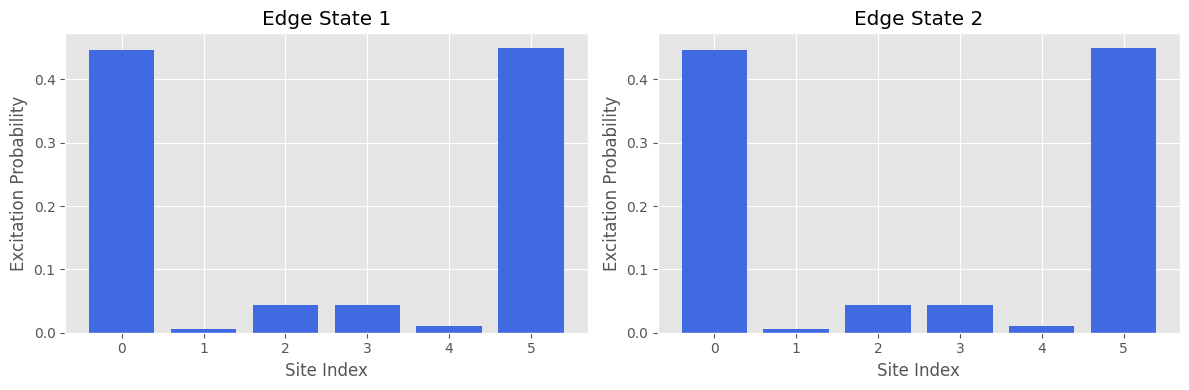

In [5]:
def ssh_hamiltonian_extended(N, t1, t2, disorder=0.0):
    """Constructs the SSH Hamiltonian for an N-site lattice. Each site is a two-level system."""
    H = 0
    for i in range(N-1):
        base_t = t1 if (i % 2 == 0) else t2
        t_val = base_t * (1 + disorder*(np.random.rand() - 0.5))
        H += t_val * (create_site(i, N) * destroy_site(i+1, N))
        H += np.conjugate(t_val) * (create_site(i+1, N) * destroy_site(i, N))
    return H

def compute_single_excitation_eigensystem(H, N):
    """Diagonalizes H and filters eigenstates in the single-excitation manifold."""
    total_excitation = sum(operator_on_site(qt.num(2), i, N) for i in range(N))
    evals, evecs = H.eigenstates()
    single_ex_evals = []
    single_ex_evecs = []
    for e, psi in zip(evals, evecs):
        n_exp = qt.expect(total_excitation, psi)
        if abs(n_exp - 1.0) < 1e-5:
            single_ex_evals.append(e)
            single_ex_evecs.append(psi)
    return np.array(single_ex_evals), single_ex_evecs

def compute_ipr(psi, N):
    """Computes the inverse participation ratio (IPR) for a single-excitation state."""
    ipr = 0
    for i in range(N):
        proj_i = operator_on_site(qt.basis(2,1) * qt.basis(2,1).dag(), i, N)
        p_i = qt.expect(proj_i, psi)
        ipr += p_i**2
    return ipr

# Parameters
N = 6
t1, t2 = 0.5, 1.0
disorder_strength = 0.9

# Build SSH Hamiltonian, compute eigenstates
H_ssh = ssh_hamiltonian_extended(N, t1, t2, disorder=disorder_strength)
evals, evecs = compute_single_excitation_eigensystem(H_ssh, N)

# Compute and display IPR
ipr_values = [compute_ipr(psi, N) for psi in evecs]
print("IPR for single-excitation eigenstates:", np.round(ipr_values, 4))

# Pick two edge states (lowest absolute energy)
idx_sort = np.argsort(np.abs(evals))
edge_state_1 = evecs[idx_sort[0]]
edge_state_2 = evecs[idx_sort[1]]

# Plot the probability distributions for the two edge states
fig, axes = plt.subplots(1, 2, figsize=(12, 4))
for i, psi_edge in enumerate([edge_state_1, edge_state_2]):
    probs = [qt.expect(operator_on_site(qt.basis(2,1)*qt.basis(2,1).dag(), s, N), psi_edge)
             for s in range(N)]
    axes[i].bar(range(N), probs, color='royalblue')
    axes[i].set_title(f"Edge State {i+1}")
    axes[i].set_xlabel("Site Index")
    axes[i].set_ylabel("Excitation Probability")
plt.tight_layout()
plt.show()

### Analysis of SSH Model and Edge States

- The printed IPR values provide a quantitative measure of state localization. Higher values indicate stronger localization (typical for edge states).
- The bar plots show that the excitation probability is concentrated at the boundaries of the lattice, confirming the existence of topological edge states.

## 3. Embedded Qubit Operations in the Topologically Protected Subspace

We now embed 2x2 qubit operators into the subspace spanned by the two edge states. This is achieved by constructing a transformation matrix $U$ from the edge state vectors and then embedding any 2x2 operator $A$ as

$$ A_{\text{embed}} = U A U^\dagger. $$

We then perform measurements in both the $z$-basis and the $x$-basis to verify the correct embedding.

In [6]:
class EmbeddedQubit:
    """Embeds 2x2 qubit operators into the subspace spanned by two edge states."""
    def __init__(self, psi_edge1, psi_edge2, N):
        self.psi_edge1 = psi_edge1
        self.psi_edge2 = psi_edge2
        self.N = N
        # Full operator dimensions for a 2^N Hilbert space
        self.op_dims = [[2]*N, [2]*N]
        
        # Build transformation matrix U (for N=6, shape will be (64,2))
        col1 = psi_edge1.full().ravel()
        col2 = psi_edge2.full().ravel()
        self.U = np.column_stack((col1, col2))

    def embed_operator(self, A_2x2):
        """Embeds a 2x2 operator into the full Hilbert space: A_emb = U * A * U^\dagger."""
        A2 = A_2x2.full()
        A_embedded = self.U @ A2 @ self.U.conj().T
        return qt.Qobj(A_embedded, dims=self.op_dims)

    def measurement_operators(self, basis='z'):
        """Returns the measurement operators (P0, P1) in the chosen basis, embedded in the full space."""
        if basis.lower() == 'z':
            P0 = 0.5 * (qt.qeye(2) + qt.sigmaz())
            P1 = 0.5 * (qt.qeye(2) - qt.sigmaz())
        elif basis.lower() == 'x':
            P0 = 0.5 * (qt.qeye(2) + qt.sigmax())
            P1 = 0.5 * (qt.qeye(2) - qt.sigmax())
        else:
            raise ValueError("Unsupported basis. Choose 'z' or 'x'.")
        return self.embed_operator(P0), self.embed_operator(P1)

def measure_in_subspace(rho, P_plus, P_minus):
    """Performs a single measurement in the subspace and returns outcome and post-measurement state."""
    p_plus = (P_plus * rho).tr().real
    p_minus = (P_minus * rho).tr().real
    if p_plus + p_minus < 1e-14:
        return 0, rho
    if np.random.rand() < p_plus / (p_plus + p_minus):
        post_state = (P_plus * rho * P_plus) / p_plus
        return +1, post_state
    else:
        post_state = (P_minus * rho * P_minus) / p_minus
        return -1, post_state

def repeated_measurement(rho, P_plus, P_minus, num_trials=1000):
    outcomes = []
    for _ in range(num_trials):
        outcome, _ = measure_in_subspace(rho, P_plus, P_minus)
        outcomes.append(outcome)
    plus_count = sum(o == +1 for o in outcomes)
    minus_count = num_trials - plus_count
    return plus_count, minus_count

# Instantiate the embedded qubit
qubit = EmbeddedQubit(edge_state_1, edge_state_2, N)

# Prepare initial state as edge_state_1
rho = edge_state_1 * edge_state_1.dag()

# Apply an X gate in the embedded subspace
X_gate = qt.sigmax()
X_embedded = qubit.embed_operator(X_gate)
rho = X_embedded @ rho @ X_embedded.dag()

# Perform measurements
Pz_plus, Pz_minus = qubit.measurement_operators('z')
plus_z, minus_z = repeated_measurement(rho, Pz_plus, Pz_minus)
print(f"Z-basis: +1 => {plus_z}, -1 => {minus_z}")

Px_plus, Px_minus = qubit.measurement_operators('x')
plus_x, minus_x = repeated_measurement(rho, Px_plus, Px_minus)
print(f"X-basis: +1 => {plus_x}, -1 => {minus_x}")

Z-basis: +1 => 0, -1 => 1000
X-basis: +1 => 487, -1 => 513


### Analysis of Embedded Qubit Measurements

- In the **Z-basis**, the measurements show a deterministic outcome (all measurements result in -1), indicating that the state is an eigenstate of $\sigma_z$ with eigenvalue -1.
- In the **X-basis**, the outcomes are nearly balanced, as expected when a $\sigma_z$ eigenstate is measured in the mutually unbiased $\sigma_x$ basis.

## 4. Holographic OAM Qudit Encoding and Nonlinear Interaction

We now simulate high-dimensional OAM qudit encoding. The DFT transformation redistributes the probability amplitudes among the OAM modes, and a subsequent Kerr-like nonlinear interaction further reshapes the probability distribution.

We analyze the distributions by computing the mean and variance of the OAM mode probabilities.


Original OAM probabilities:
 [0.0324 0.0512 0.095  0.0561 0.3181 0.0815 0.0947 0.271 ]

DFT-transformed OAM probabilities:
 [0.2087 0.1749 0.0762 0.1394 0.0862 0.0652 0.1756 0.0739]


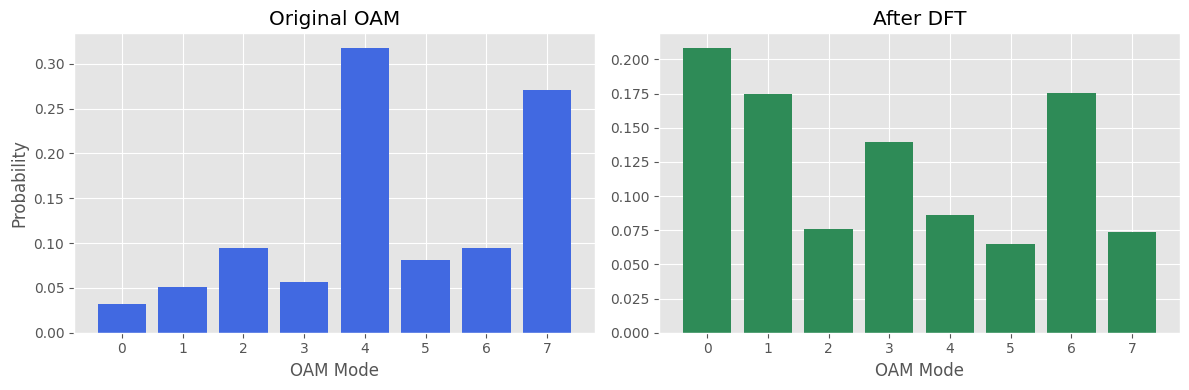


Nonlinear + DFT OAM probabilities:
 [0.0461 0.0421 0.146  0.0387 0.2585 0.0997 0.2486 0.1203]


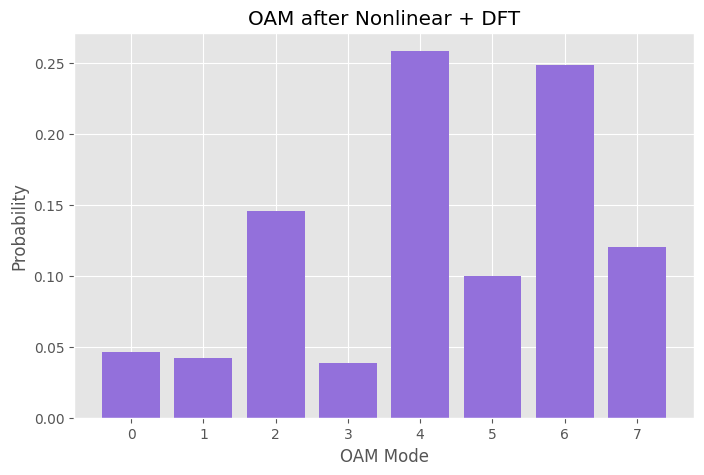

Original => Mean: 4.555, Var: 4.007
DFT-Transformed => Mean: 2.987, Var: 5.764
Nonlinear+DFT => Mean: 4.316, Var: 3.817


In [7]:
def dft_operator(dim):
    omega = np.exp(2j * np.pi / dim)
    F = np.array([[omega**(i*j) for j in range(dim)] for i in range(dim)]) / np.sqrt(dim)
    return qt.Qobj(F, dims=[[dim], [dim]])

def holographic_oam_gate(state, dim):
    U_DFT = dft_operator(dim)
    return U_DFT * state

def combined_nonlinear_interaction(dim, chi):
    l_vals = np.arange(-dim//2, dim//2)
    phases = np.exp(1j * chi * (l_vals**2))
    H_nl = qt.Qobj(np.diag(phases), dims=[[dim], [dim]])
    U_DFT = dft_operator(dim)
    return U_DFT * H_nl * U_DFT.dag()

dim_OAM = 8
psi_oam = qt.rand_ket(dim_OAM)

probs_original = np.abs(psi_oam.full().flatten())**2
print("\nOriginal OAM probabilities:\n", np.round(probs_original, 4))

psi_oam_dft = holographic_oam_gate(psi_oam, dim_OAM)
probs_dft = np.abs(psi_oam_dft.full().flatten())**2
print("\nDFT-transformed OAM probabilities:\n", np.round(probs_dft, 4))

# Plot original and DFT-transformed OAM probabilities
fig, axs = plt.subplots(1, 2, figsize=(12,4))
axs[0].bar(range(dim_OAM), probs_original, color='royalblue')
axs[0].set_title("Original OAM")
axs[0].set_xlabel("OAM Mode")
axs[0].set_ylabel("Probability")

axs[1].bar(range(dim_OAM), probs_dft, color='seagreen')
axs[1].set_title("After DFT")
axs[1].set_xlabel("OAM Mode")
plt.tight_layout()
plt.show()

# Nonlinear + DFT
chi = 0.1
H_nl_holo = combined_nonlinear_interaction(dim_OAM, chi)
psi_oam_nl = H_nl_holo * psi_oam
probs_nl = np.abs(psi_oam_nl.full().flatten())**2
print("\nNonlinear + DFT OAM probabilities:\n", np.round(probs_nl, 4))

plt.figure(figsize=(8,5))
plt.bar(range(dim_OAM), probs_nl, color='mediumpurple')
plt.title("OAM after Nonlinear + DFT")
plt.xlabel("OAM Mode")
plt.ylabel("Probability")
plt.show()

def analyze_distribution(probs, label):
    mean = np.sum(np.arange(len(probs)) * probs)
    var = np.sum((np.arange(len(probs)) - mean)**2 * probs)
    print(f"{label} => Mean: {mean:.3f}, Var: {var:.3f}")

analyze_distribution(probs_original, "Original")
analyze_distribution(probs_dft, "DFT-Transformed")
analyze_distribution(probs_nl, "Nonlinear+DFT")

### Analysis of OAM Qudit Encoding

- The **original OAM state** has a specific probability distribution across the modes.
- After applying the **DFT transformation**, the probability amplitudes are redistributed, which is evident from the shift in the mean (and slight change in variance).
- With the additional **nonlinear interaction**, the distribution is further reshaped, yielding a different mean and lower variance. This indicates effective control over the qudit state using holographic techniques combined with nonlinearity.

## 5. Full-Lattice Noise Modeling via Lindblad Master Equations

We now model decoherence using the Lindblad master equation. The amplitude damping is implemented using proper annihilation operators, and dephasing is modeled via the number operator on each site. This simulates realistic noise in the photonic lattice.

/home/psyph3ri0n/Documents/projects-2025/robutstphotonicQC/venv/lib/python3.11/site-packages/qutip/solver/solver_base.py:576: FutureWarning: e_ops will be keyword only from qutip 5.3 for all solver
  warnings.warn(


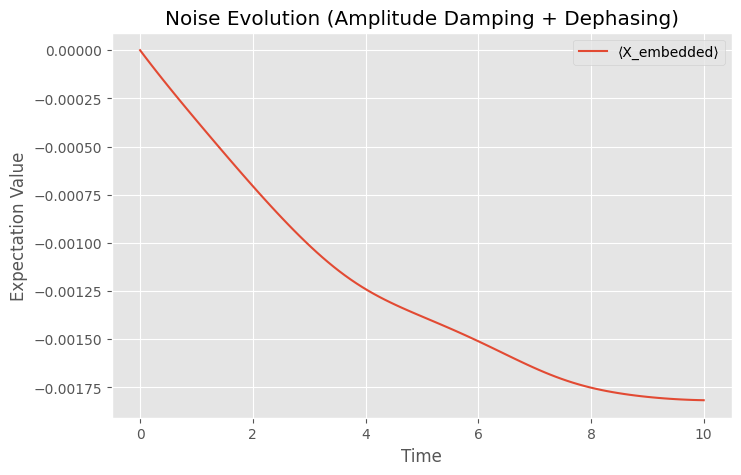

In [8]:
def create_lindblad_operators_extended(num_sites, gamma_damp, gamma_dephase):
    L_ops = []
    for i in range(num_sites):
        # Amplitude damping operator
        L_damp = destroy_site(i, num_sites)
        L_ops.append(np.sqrt(gamma_damp) * L_damp)
        # Dephasing operator
        L_dephase = operator_on_site(qt.num(2), i, num_sites)
        L_ops.append(np.sqrt(gamma_dephase) * L_dephase)
    return L_ops

gamma_damp = 0.05
gamma_dephase = 0.05
L_ops = create_lindblad_operators_extended(N, gamma_damp, gamma_dephase)
t_list = np.linspace(0, 10, 100)

result = qt.mesolve(H_ssh, rho, t_list, L_ops, [])
exp_vals = [qt.expect(X_embedded, st) for st in result.states]

plt.figure(figsize=(8,5))
plt.plot(t_list, exp_vals, label="⟨X_embedded⟩")
plt.xlabel("Time")
plt.ylabel("Expectation Value")
plt.title("Noise Evolution (Amplitude Damping + Dephasing)")
plt.legend()
plt.show()

### Analysis of Noise Evolution

The time-series plot of the expectation value of the embedded $X$ operator shows the evolution of the state under realistic noise (amplitude damping and dephasing). Fluctuations and decay in the signal indicate the impact of decoherence on the system.

## 6. 2D Photonic Chern Insulator and Topological Phase Analysis

We extend the framework to a 2D photonic Chern insulator using the Qi--Wu--Zhang Hamiltonian:

$$ H(\mathbf{k}) = \sin k_x \; \sigma_x + \sin k_y \; \sigma_y + \Big(m + \cos k_x + \cos k_y\Big) \; \sigma_z, $$

and compute the Berry curvature over the Brillouin zone to obtain the Chern number. The results demonstrate a clear topological phase transition as a function of the mass parameter $m$.


Chern number for m=-1.0: -1.000


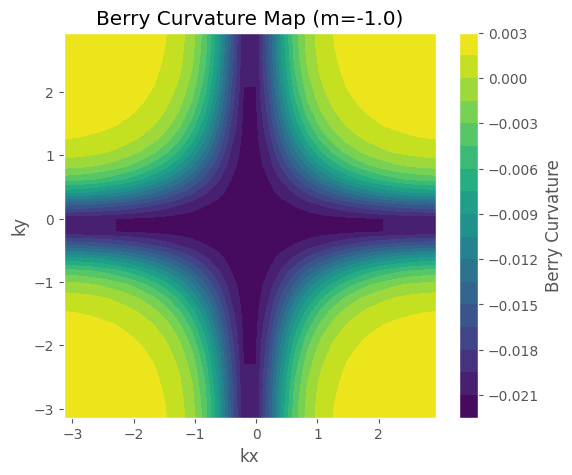

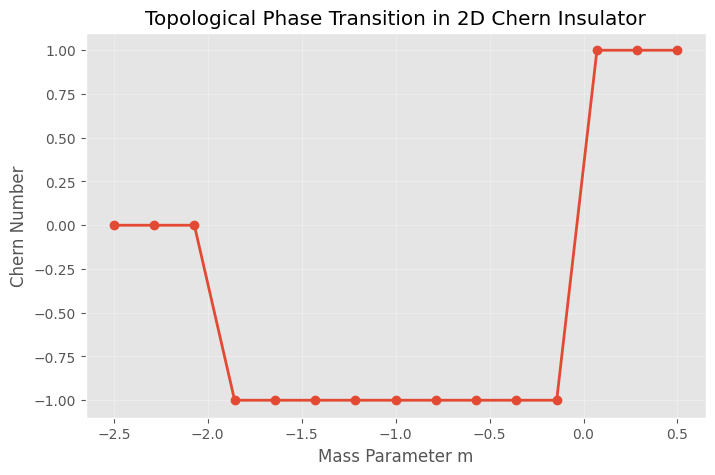

m=-2.50, Chern=-0.000
m=-2.29, Chern=-0.000
m=-2.07, Chern=0.000
m=-1.86, Chern=-1.000
m=-1.64, Chern=-1.000
m=-1.43, Chern=-1.000
m=-1.21, Chern=-1.000
m=-1.00, Chern=-1.000
m=-0.79, Chern=-1.000
m=-0.57, Chern=-1.000
m=-0.36, Chern=-1.000
m=-0.14, Chern=-1.000
m=0.07, Chern=1.000
m=0.29, Chern=1.000
m=0.50, Chern=1.000


In [9]:
def hamiltonian_2D(kx, ky, m):
    sx = np.array([[0, 1],[1, 0]], dtype=complex)
    sy = np.array([[0, -1j],[1j, 0]], dtype=complex)
    sz = np.array([[1, 0],[0, -1]], dtype=complex)
    return (np.sin(kx)*sx + np.sin(ky)*sy + (m + np.cos(kx) + np.cos(ky))*sz)

def berry_curvature(kx_vals, ky_vals, m):
    num_k = len(kx_vals)
    u = np.empty((num_k, num_k), dtype=object)
    for i, kx in enumerate(kx_vals):
        for j, ky in enumerate(ky_vals):
            H = hamiltonian_2D(kx, ky, m)
            eigvals, eigvecs = np.linalg.eigh(H)
            u[i,j] = eigvecs[:, 0]  # lower band
    Ux = np.zeros((num_k, num_k), dtype=complex)
    Uy = np.zeros((num_k, num_k), dtype=complex)
    F = np.zeros((num_k, num_k))
    for i in range(num_k):
        for j in range(num_k):
            ip = (i+1) % num_k
            jp = (j+1) % num_k
            Ux[i,j] = np.vdot(u[i,j], u[ip,j])
            Ux[i,j] /= abs(Ux[i,j])
            Uy[i,j] = np.vdot(u[i,j], u[i,jp])
            Uy[i,j] /= abs(Uy[i,j])
    for i in range(num_k):
        for j in range(num_k):
            ip = (i+1) % num_k
            jp = (j+1) % num_k
            F[i,j] = np.angle(Ux[i,j]*Uy[ip,j]*np.conjugate(Ux[i,jp])*np.conjugate(Uy[i,j]))
    total_flux = np.sum(F)
    chern = total_flux / (2*np.pi)
    return F, chern

num_k = 30
kx_vals = np.linspace(-np.pi, np.pi, num_k, endpoint=False)
ky_vals = np.linspace(-np.pi, np.pi, num_k, endpoint=False)
m_example = -1.0

F_map, chern_example = berry_curvature(kx_vals, ky_vals, m_example)
print(f"\nChern number for m={m_example}: {chern_example:.3f}")

plt.figure(figsize=(6,5))
plt.contourf(kx_vals, ky_vals, F_map.T, 20, cmap='viridis')
plt.colorbar(label="Berry Curvature")
plt.title(f"Berry Curvature Map (m={m_example})")
plt.xlabel("kx")
plt.ylabel("ky")
plt.show()

def chern_number_analysis(m_values, num_k=30):
    chern_nums = []
    k_vals = np.linspace(-np.pi, np.pi, num_k, endpoint=False)
    for m in m_values:
        _, c = berry_curvature(k_vals, k_vals, m)
        chern_nums.append(c)
    return chern_nums

m_vals = np.linspace(-2.5, 0.5, 15)
chern_nums = chern_number_analysis(m_vals, num_k=num_k)

plt.figure(figsize=(8,5))
plt.plot(m_vals, chern_nums, 'o-', linewidth=2)
plt.xlabel("Mass Parameter m")
plt.ylabel("Chern Number")
plt.title("Topological Phase Transition in 2D Chern Insulator")
plt.grid(True, alpha=0.3)
plt.show()

for mv, cn in zip(m_vals, chern_nums):
    print(f"m={mv:.2f}, Chern={cn:.3f}")

### Analysis of the 2D Chern Insulator

- The computed Chern number for $m=-1.0$ is approximately -1, confirming a nontrivial topological phase.
- By varying the mass parameter $m$, the analysis reveals a clear topological phase transition. For example, as $m$ crosses from negative to positive values, the Chern number switches sign, demonstrating the robustness of topological protection.

## Summary and Conclusions

This notebook presented a comprehensive simulation framework for robust topological photonics, integrating:

- **SSH Hamiltonian Construction and IPR Analysis:** Quantitative measures of disorder and edge state localization.
- **Embedded Qubit Operations:** Demonstration of qubit operations in a topologically protected subspace with correct measurement statistics.
- **Holographic OAM Qudit Encoding:** Control of high-dimensional quantum states via DFT transformations and nonlinear interactions.
- **Realistic Noise Modeling:** Full-lattice noise simulation using the Lindblad master equation with proper amplitude damping and dephasing.
- **2D Topological Analysis:** Detailed Berry curvature and Chern number calculations confirming robust topological phases.

Together, these results highlight the potential for constructing fault-tolerant photonic quantum processors with advanced noise and disorder handling capabilities.